In [1]:
import pennylane as qml
import numpy as np
from dataload import get_data
import matplotlib.pyplot as plt
import pennylane as qml
import random
import torch
import seaborn as sns

In [2]:
X_train, X_test, y_train, y_test = get_data(name='iris', ev_size=0.2)

In [3]:
dev = qml.device("default.qubit", wires=4)

def quantum_circuit(structure, data):
    for i, (gate, qubits, feature) in enumerate(structure):
        if gate == "RX":
            qml.RX(data[feature], wires=qubits[0])
        elif gate == "RY":
            qml.RY(data[feature], wires=qubits[0])
        elif gate == "RZ":
            qml.RZ(data[feature], wires=qubits[0])
        elif gate == "CNOT":
            qml.CNOT(wires=(qubits[0], qubits[1]))

In [4]:
@qml.qnode(dev)
def embedding_circuit(structure, data):
    quantum_circuit(structure, data)
    return qml.state()

In [5]:
def generate_random_structure(num_qubits, num_gates, feature_dim):
    structure = []
    for _ in range(num_gates):
        gate = random.choice(["RX", "RY", "RZ", "CNOT"])
        qubits = random.sample(range(num_qubits), 2 if gate == "CNOT" else 1)
        feature_idx = random.randint(0, feature_dim - 1)
        structure.append((gate, qubits, feature_idx))
    return structure

In [6]:
def fitness_function(structure, X_batch, y_batch):
    states = []
    for data in X_batch:
        embedding = embedding_circuit(structure, data)
        embedding_tensor = torch.tensor(embedding)
        states.append(embedding_tensor)
    states = torch.stack(states)
    states = states / torch.norm(states, dim=1, keepdim=True)
    states_conj = torch.conj(states)
    inner_products = torch.matmul(states_conj, states.T)
    fidelity_matrix = torch.abs(inner_products) ** 2
    labels = torch.tensor(y_batch).view(-1)
    label_products = torch.outer(labels, labels)
    loss_matrix = (fidelity_matrix - 0.5 * (1 + label_products)) ** 2
    batch_size = X_batch.shape[0]
    indices = torch.triu_indices(batch_size, batch_size, offset=1)
    loss_values = loss_matrix[indices[0], indices[1]]
    loss = torch.mean(loss_values)
    return loss

In [7]:
POPULATION_SIZE = 64
NUM_GENERATIONS = 1000
NUM_GATES = 16
NUM_QUBITS = 4
FEATURE_DIMENSION = X_train.shape[1]

In [8]:
population = [generate_random_structure(NUM_QUBITS, NUM_GATES, FEATURE_DIMENSION) for _ in range(POPULATION_SIZE)]
training_loss = []
evaluation_loss = []
fitness_history = []

In [9]:
for generation in range(NUM_GENERATIONS):
    ## fitness evaluation
    fitness = [fitness_function(structure, X_train, y_train) for structure in population]
    mean_fitness = np.mean(fitness)
    min_fitness = np.min(fitness)
    print(f"Generation {generation + 1}: Mean Fitness = {mean_fitness:.4f}, Min Fitness = {min_fitness:.4f}")
    training_loss.append([mean_fitness, min_fitness])

    ## criteria for early stopping
    if min_fitness < 0.01:
        print("Solution found!")
        break
    ## early stopping for overfitting
    if generation + 1 > 20 : 
        early_stop = np.sum(np.array(training_loss)[-20:,1] == np.array(training_loss)[-1,1])
        if early_stop == 20:
            print("Early stopping")
            break
    

    
    ## evaluation
    ev_fitness = [fitness_function(structure, X_test, y_test) for structure in population]
    evaluation_loss.append([np.mean(ev_fitness), np.min(ev_fitness)])

    if (generation == 0) or ((generation + 1) % 10 == 0):
        fitness_history.append(fitness)
    
    ## training is over
    if generation + 1 == NUM_GENERATIONS:
        print("Generation is over")
        break
    if mean_fitness == min_fitness:
        break

    ## selection
    sorted_population = [x for _, x in sorted(zip(fitness, population), key=lambda pair: pair[0], reverse=False)]
    population = sorted_population[:POPULATION_SIZE // 2]

    ## crossover
    offspring = []
    for _ in range(POPULATION_SIZE // 2):
        parent1, parent2 = random.sample(population, 2)
        crossover_point = random.randint(1, NUM_GATES - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        offspring.append(child)
    
    ## mutation
    for child in offspring:
        if random.random() < 0.1:  # Mutation probability
            gate_idx = random.randint(0, NUM_GATES - 1)
            gate = random.choice(["RX", "RY", "RZ", "CNOT"])
            if gate == "CNOT":
                qubits = random.sample(range(NUM_QUBITS), 2)
            else:
                qubits = [random.choice(range(NUM_QUBITS))]
            feature_idx = random.randint(0, FEATURE_DIMENSION - 1)
            child[gate_idx] = (gate, qubits, feature_idx)
    
    ## update population
    population += offspring

Generation 1: Mean Fitness = 0.2895, Min Fitness = 0.1882
Generation 2: Mean Fitness = 0.2680, Min Fitness = 0.1737
Generation 3: Mean Fitness = 0.2475, Min Fitness = 0.1416
Generation 4: Mean Fitness = 0.2308, Min Fitness = 0.1416
Generation 5: Mean Fitness = 0.2133, Min Fitness = 0.1295
Generation 6: Mean Fitness = 0.1923, Min Fitness = 0.1218
Generation 7: Mean Fitness = 0.1815, Min Fitness = 0.1203
Generation 8: Mean Fitness = 0.1667, Min Fitness = 0.0855
Generation 9: Mean Fitness = 0.1473, Min Fitness = 0.0701
Generation 10: Mean Fitness = 0.1356, Min Fitness = 0.0701
Generation 11: Mean Fitness = 0.1170, Min Fitness = 0.0701
Generation 12: Mean Fitness = 0.1052, Min Fitness = 0.0521
Generation 13: Mean Fitness = 0.0981, Min Fitness = 0.0521
Generation 14: Mean Fitness = 0.0845, Min Fitness = 0.0521
Generation 15: Mean Fitness = 0.0758, Min Fitness = 0.0521
Generation 16: Mean Fitness = 0.0705, Min Fitness = 0.0521
Generation 17: Mean Fitness = 0.0685, Min Fitness = 0.0521
Genera

In [1]:
plt.title('Training min and mean Loss')
plt.plot(np.array(training_loss)[:,0])
plt.plot(np.array(training_loss)[:,1], "--")
plt.legend(['Population mean loss', 'Population min loss'])
plt.show()

NameError: name 'plt' is not defined

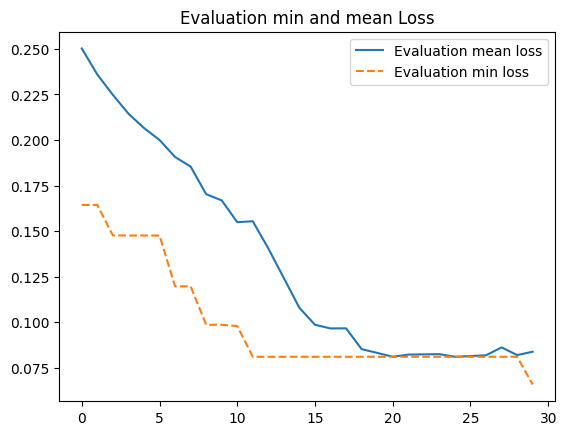

In [11]:
plt.title('Evaluation min and mean Loss')
plt.plot(np.array(evaluation_loss)[:,0])
plt.plot(np.array(evaluation_loss)[:,1], "--")
plt.legend(['Evaluation mean loss', 'Evaluation min loss'])
plt.show()

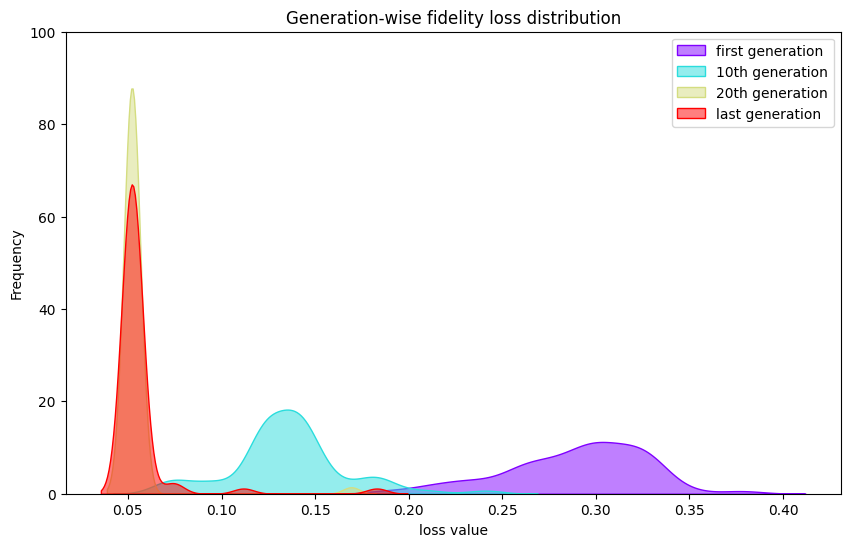

In [12]:
plt.figure(figsize=(10, 6))

# 색상 팔레트 생성
colors = plt.cm.rainbow(np.linspace(0, 1, len(fitness_history)))

for i, (generation_fitness, color) in enumerate(zip(fitness_history, colors)):
    # tensor를 numpy array로 변환
    generation_fitness_np = [tensor.detach().cpu().item() for tensor in generation_fitness]
    
    if i == 0:
        sns.kdeplot(x=generation_fitness_np, bw_adjust=0.7, fill = True, label='first generation', color=color, alpha = 0.5)
    elif i == len(fitness_history)-1:
        sns.kdeplot(x=generation_fitness_np, bw_adjust=0.7, fill = True, label='last generation', color=color, alpha = 0.5)
    else:
        sns.kdeplot(x=generation_fitness_np, bw_adjust=0.7, fill = True, label=f'{i*10}th generation', color=color, alpha = 0.5)

plt.title('Generation-wise fidelity loss distribution')
plt.xlabel('loss value')
plt.ylabel('Frequency')
plt.ylim(0,100)
plt.legend()
plt.show()

In [13]:
population

[[('RZ', [0], 3),
  ('CNOT', [2, 3], 1),
  ('RZ', [0], 1),
  ('CNOT', [0, 2], 1),
  ('RZ', [3], 1),
  ('RZ', [0], 0),
  ('RX', [2], 2),
  ('RY', [2], 2),
  ('RZ', [0], 0),
  ('CNOT', [0, 2], 3),
  ('RY', [2], 2),
  ('CNOT', [0, 2], 1),
  ('RX', [3], 2),
  ('CNOT', [0, 3], 3),
  ('CNOT', [1, 3], 2),
  ('CNOT', [0, 2], 2)],
 [('RZ', [0], 3),
  ('CNOT', [2, 3], 1),
  ('RZ', [3], 3),
  ('RZ', [0], 1),
  ('RZ', [3], 1),
  ('RZ', [0], 0),
  ('RX', [2], 2),
  ('RY', [2], 2),
  ('RZ', [0], 0),
  ('CNOT', [0, 2], 3),
  ('RY', [2], 2),
  ('CNOT', [0, 2], 1),
  ('RX', [3], 2),
  ('CNOT', [0, 3], 3),
  ('CNOT', [1, 3], 2),
  ('CNOT', [0, 2], 2)],
 [('RZ', [1], 3),
  ('CNOT', [1, 0], 0),
  ('RZ', [3], 3),
  ('RZ', [0], 1),
  ('RZ', [2], 1),
  ('RZ', [0], 0),
  ('RX', [2], 2),
  ('RY', [2], 2),
  ('RZ', [0], 0),
  ('CNOT', [0, 2], 3),
  ('RY', [2], 2),
  ('CNOT', [0, 2], 1),
  ('RX', [3], 2),
  ('CNOT', [0, 3], 3),
  ('CNOT', [1, 3], 2),
  ('CNOT', [0, 2], 2)],
 [('RZ', [0], 3),
  ('CNOT', [2, 3], 1